In [1]:
import torch
import torch.nn.functional as F

# 32-bit floating point
# floating-point arithmetic: https://en.wikipedia.org/wiki/Floating-point_arithmetic
dtype = torch.float32 
# put tensor on cpu(or you can try GPU)
device = torch.device("cuda")

# our data
POLY_DEGREE = 2
x = 2.0
x = [x** i for i in range(POLY_DEGREE + 1)]
w = torch.randn(POLY_DEGREE + 1, device=device, requires_grad = True)
x = torch.tensor(x, dtype=dtype, device=device, requires_grad = True)

target = 2.4
target = torch.tensor([target], dtype=dtype, device=device, requires_grad = True)

y = torch.sum(w* x) # forward
F.mse_loss(y, target.view_as(y)).backward() # backward

# (a) calculate the gradients manually
# y = w_0 + w_1 x + w_2 x^2
# grad(w) = x * (y - target) * 2
grad = x* (y - target)* 2
print('(a) The gradients of w are', grad.data.cpu().numpy())

# (b) double-check by PyTorch AutoGrad
print('(b) The gradients of w are', w.grad.data.cpu().numpy())

# simulate taking gradient descent steps
w.grad.zero_()
for i in range(10):
    y = torch.sum(w* x) # forward
    loss = F.mse_loss(y, target.view_as(y))
    loss.backward() # backward
    w.data.add_(-0.01, w.grad)
    w.grad.zero_()
    print('w is', w.data.cpu().numpy(), 'and y is', y.item())



(a) The gradients of w are [23.661922 47.323845 94.64769 ]
(b) The gradients of w are [23.661922 47.323845 94.64769 ]
w is [ 1.2533165 -1.1973792  2.6008496] and y is 14.230960845947266
w is [ 1.1160774 -1.4718575  2.051893 ] and y is 9.261957168579102
w is [ 1.0364788 -1.6310549  1.7334982] and y is 6.379934310913086
w is [ 0.9903115 -1.7233894  1.5488293] and y is 4.708361625671387
w is [ 0.9635345 -1.7769434  1.4417213] and y is 3.7388501167297363
w is [ 0.9480038 -1.8080047  1.3795987] and y is 3.176532745361328
w is [ 0.938996  -1.8260204  1.3435676] and y is 2.850389242172241
w is [ 0.9337715 -1.8364694  1.3226696] and y is 2.6612255573272705
w is [ 0.93074125 -1.8425299   1.3105488 ] and y is 2.551511287689209
w is [ 0.92898375 -1.8460449   1.3035187 ] and y is 2.4878766536712646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)


-----Linear approximation-----
Loss: 0.004714 after 781 batches
==> Learned function:	y = +0.28 x^4 -0.31 x^3 -1.78 x^2 -1.44 x^1 +1.74
==>  Actual function:	y = +0.20 x^4 -0.27 x^3 -1.74 x^2 -1.45 x^1 +1.71
-----Non-Linear approximation-----
Loss: 0.411502 after 1577 batches


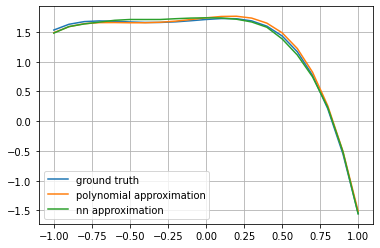

In [2]:
from __future__ import print_function
from itertools import count

import torch
import torch.autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

#---------- Generate Target Polynomial Function ----------#
# A polynomial function: y = w_1* x^1 + w_2* x^2 + ... + w_n* x^n + b
# Learnable parameters: w_1, w_2, ..., w_n, b
# n = POLY_DEGREE
POLY_DEGREE = 4
w_target = torch.randn(POLY_DEGREE, 1) 
b_target = torch.randn(1)

#---------- Define Auxiliary Functions ----------#
def make_features(x):
    '''Builds features i.e. a matrix with columns [x, x^2, x^3, x^4].'''
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in range(1, POLY_DEGREE+1)], 1)

def f(x):
    '''Approximated function.'''
    return x.mm(w_target) + b_target[0]

def print_poly(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

def get_batch_poly(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    return Variable(x), Variable(y)

def get_batch_nn(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    x = torch.randn(batch_size, 1)
    x_poly = make_features(x.squeeze())
    y = f(x_poly)
    return Variable(x), Variable(y)

#---------- Define Model ----------#
# Linear Model 
model_poly = torch.nn.Linear(w_target.size(0), 1)
optimizer_poly = optim.SGD(model_poly.parameters(), lr = 0.1, momentum=0.0)

# Non-Linear Model 
_model_nn  = [torch.nn.Linear(1, 256)]
_model_nn += [torch.nn.ReLU(True)]
_model_nn += [torch.nn.Linear(256, 1)]
model_nn = torch.nn.Sequential(*_model_nn)
optimizer_nn = optim.SGD(model_nn.parameters(), lr = 0.1, momentum=0.0)

#---------- Train ----------#
# Linear Model
torch.manual_seed(24)
for batch_idx_poly in count(1):

    # Generate training data
    batch_x, batch_y = get_batch_poly()              

    # Forward pass
    optimizer_poly.zero_grad()
    output = model_poly(batch_x)                     
    loss = F.smooth_l1_loss(output, batch_y)  
    loss_data = loss.item()

    # Backward pass
    loss.backward() 
    optimizer_poly.step() 

    # Stop iteration
    if loss_data < 1e-3:  
        break

# Non-Linear Model
torch.manual_seed(24)
for batch_idx_nn in count(1):

    # Generate training data
    batch_x, batch_y = get_batch_nn()              

    # Forward pass
    optimizer_nn.zero_grad()
    output = model_nn(batch_x)                   
    loss = F.smooth_l1_loss(output, batch_y)  
    loss_data = loss.item()

    # Backward pass
    loss.backward() 
    optimizer_nn.step() 

    # Stop iteration
    if loss_data < 1e-3:  
        break

#---------- Print ----------#
# Linear Model
torch.manual_seed(32)
batch_x, batch_y = get_batch_poly(1000)
output = model_poly(batch_x)                     
loss_data = F.smooth_l1_loss(output, batch_y).item()
print('-----Linear approximation-----')
print('Loss: {:.6f} after {} batches'.format(loss_data, batch_idx_poly))
print('==> Learned function:\t' + print_poly(model_poly.weight.data.view(-1), model_poly.bias.data))
print('==>  Actual function:\t' + print_poly(w_target.view(-1), b_target))

# Non-Linear Model
torch.manual_seed(32)
batch_x, batch_y = get_batch_nn(1000)
output = model_nn(batch_x)                     
loss_data = F.smooth_l1_loss(output, batch_y).item()
print('-----Non-Linear approximation-----')
print('Loss: {:.6f} after {} batches'.format(loss_data, batch_idx_nn))

points = torch.arange(-1, 1.1, 0.1)
features = make_features(points)
y1, y2, y3 = [], [], []
for i in range(len(points)):
    y1 += [f(features[i].unsqueeze(0)).item()]
    y2 += [model_poly(features[i].unsqueeze(0)).item()]
    y3 += [model_nn(points[i].unsqueeze(0)).item()]

plt.figure()
plt.plot(points, y1, label='ground truth')
plt.plot(points, y2, label='polynomial approximation')
plt.plot(points, y3, label= 'nn approximation')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# PyTorch tutorial codes for course Advanced Machine Learning
# main.py: trainig neural networks for MNIST classification
import time, datetime
from __future__ import print_function
import torch
import argparse
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets, transforms

class ConvNet(nn.Module):
    ''' convolutional neural network '''
    def __init__(self):
        super(ConvNet, self).__init__()
        nf = 8
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, etc.)
        self.conv1 = nn.Conv2d(    1, nf* 1, 5, 1, 0) #24
        self.conv2 = nn.Conv2d(nf* 1, nf* 2, 4, 2, 1) #12
        self.conv3 = nn.Conv2d(nf* 2, nf* 4, 5, 1, 0) #8
        self.conv4 = nn.Conv2d(nf* 4, nf* 8, 4, 2, 1) #4
        self.conv5 = nn.Conv2d(nf* 8,    10, 4, 1, 0) #1
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = torch.flatten(x, 1)
        return F.log_softmax(x, dim=1)

class FCNet(nn.Module):
    ''' fully-connected neural network '''
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100,  10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output




def get_dataloaders(args):
    ''' define training and testing data loader'''
    # load trainig data loader
    kwargs = {'num_workers': 4, 'pin_memory': True} if args.use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
            datasets.MNIST('./Data/mnist', train=True, download=True, 
                               transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=args.batch_size, shuffle=True, drop_last=True, **kwargs)

    # load testing data loader
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('./Data/mnist', train=False, 
                               transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=args.test_batch_size, shuffle=True, drop_last=True, **kwargs)
    
    return train_loader, test_loader

def get_model(args):
    ''' define model '''
    model = None
    if args.model == 'Net':
        model = Net()
    elif args.model == 'FCNet':
        model = FCNet()
    elif args.model == 'ConvNet':
        model = ConvNet()
    else:
        raise ValueError('The model is not defined!!')
            
    print('---Model Information---')
    print('Net:', model)
    print('Use GPU:', args.use_cuda)
    return model.to(args.device)
	
def get_optimizer(args, model):
    ''' define optimizer '''
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    print('\n---Optimization Information---')
    print('optimizer: SGD')
    print('batch size:', args.batch_size)
    print('lr:', args.lr)
    print('momentum:', args.momentum)
    return optimizer

def train(args, model, optimizer, train_loader, epoch):
    ''' define training function '''
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(args.device), target.to(args.device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, test_loader):
    ''' define testing function '''
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(args.device), target.to(args.device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
           test_loss, correct, len(test_loader.dataset),
           100. * correct / len(test_loader.dataset)))
        
if __name__ == '__main__':
    start_time = datetime.datetime.now().replace(microsecond=0)
    print('[Starte at %s]'%start_time)
    

    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                        help='input batch size for training (default: 128)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--model', type=str, default='Net',
                        help='architecture of moel')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')

    args = parser.parse_args(['--batch-size', '128', '--test-batch-size', '1000'])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    args.use_cuda = use_cuda
    args.device = torch.device("cuda" if use_cuda else "cpu")

    train_loader, test_loader = get_dataloaders(args)
    model = get_model(args)
    optimizer = get_optimizer(args, model)
    
    print('\n--- Training ---')
    for epoch in range(1, args.epochs + 1):
        train(args, model, optimizer, train_loader, epoch)
        test(args, model, test_loader)
        current_time = datetime.datetime.now().replace(microsecond=0)
        print('Time Interval:', current_time - start_time, '\n')


[Starte at 2021-07-28 01:27:14]
Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./Data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./Data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./Data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./Data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/mnist/MNIST/raw

---Model Information---
Net: Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Use GPU: True


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten


---Optimization Information---
optimizer: SGD
batch size: 128
lr: 0.01
momentum: 0.9

--- Training ---


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315159
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.361707
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.301657
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.177670
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.148368
Test set: Average loss: 0.0826, Accuracy: 9729/10000 (97%)
Time Interval: 0:00:27 

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.113470
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.074334
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.112149
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.099661
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.127597
Test set: Average loss: 0.0498, Accuracy: 9829/10000 (98%)
Time Interval: 0:00:37 

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.097648
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.034344
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.055846
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.112542
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.203803
Test set: Average loss: 0.0396, Accuracy: 9868/10000 (99%)
Time Interval: 0:00:46 

Train Epoch: 